In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import warnings
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import f1_score
random_state =537
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from sklearn.preprocessing import LabelEncoder

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

import time

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
import gc
gc.collect()

0

In [2]:
test = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/test.csv")
train = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/train.csv")
sub = pd.read_csv("/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/sample_submission.csv")
test2 = test.copy()


In [3]:
label = "LABEL"
product_feat_cols = list(train.iloc[:,-42:-1].columns)
soru_cols = [col for col in train.columns if col.startswith("SORU") ]
drop_col = [
            "FLAG",
            "MUSTERI_ID",
            ]

In [4]:
xls = pd.ExcelFile('/kaggle/input/anadolu-hayat-emeklilik-datathon-2024/Urun Ozellikleri.xlsx')
urun = pd.read_excel(xls, 'Sayfa1')
urun.drop([31,32],inplace=True)
new_cols = []


for a in tqdm(['Branş ', 'Grup/Ferdi', 'Kredili/Kredisiz','Biriktiren/ Koruma', 'Sigortas Süresi ']):
    for i in urun[a].unique():
        train[f"{a.lower()}_{i}"] = 0 
        test[f"{a.lower()}_{i}"] = 0 
        new_cols.append(f"{a.lower()}_{i}")
        for ii in urun.loc[urun[a] == i]["Ürün "].unique():
            train.loc[train[ii]!= 0,[f"{a.lower()}_{i}"]] = 1
            test.loc[test[ii]!= 0,[f"{a.lower()}_{i}"]] = 1

100%|██████████| 5/5 [00:01<00:00,  4.23it/s]


In [5]:
# def prod_exc(row):
#     return [col for col, val in row.items() if val != 0]

# # tqdm ile veri çerçevesi üzerinde ilerleyerek işlemi hızlandırma

# train["products_list"] = list(tqdm(train[product_feat_cols].progress_apply(prod_exc, axis=1)))
# test["products_list"] = list(tqdm(test[product_feat_cols].progress_apply(prod_exc, axis=1)))
# train["products_list"] = train.products_list.apply(lambda x:len(x))
# test["products_list"] = test.products_list.apply(lambda x:len(x))

In [6]:
train.drop(drop_col,axis=1,inplace=True)
test.drop(drop_col,axis=1,inplace=True)

test.loc[test.IL.isna(),["IL"]] = 34

train.loc[train.SORU_MEDENI_HAL_CVP.isna(),["SORU_MEDENI_HAL_CVP"]] = "Married"
test.loc[test.SORU_MEDENI_HAL_CVP.isna(),["SORU_MEDENI_HAL_CVP"]] ="Married"

train.isna().sum().sum(),test.isna().sum().sum()

(8246658, 1965679)

In [7]:
train["yas"] = (train["PP_YAS"]/12).astype(int)
test["yas"] = (test["PP_YAS"]/12).astype(int)

In [8]:
x = train.drop([label],axis=1)
y = train[label] 

In [9]:
le = LabelEncoder()
y = pd.DataFrame(le.fit_transform(y),columns=["LABEL"])

In [10]:
x = x.drop(["SON_AY_KATKI_MIKTARI","SON_AY_KATKI_ADET","SON_CEYREK_KATKI_MIKTARI","SON_CEYREK_KATKI_ADET",
        "SON_SENE_KATKI_MIKTARI","SON_SENE_KATKI_ADET","PP_YAS",'kredili/kredisiz_Krediden bağımsız'],axis=1)
test = test.drop(["SON_AY_KATKI_MIKTARI","SON_AY_KATKI_ADET","SON_CEYREK_KATKI_MIKTARI","SON_CEYREK_KATKI_ADET",
        "SON_SENE_KATKI_MIKTARI","SON_SENE_KATKI_ADET","PP_YAS",'kredili/kredisiz_Krediden bağımsız'],axis=1)

x.loc[(x.SORU_MEDENI_HAL_CVP != "Married") & (x.SORU_MEDENI_HAL_CVP!="Single"),["SORU_MEDENI_HAL_CVP"]] = "other"
test.loc[(test.SORU_MEDENI_HAL_CVP != "Married") & (test.SORU_MEDENI_HAL_CVP!="Single"),["SORU_MEDENI_HAL_CVP"]] = "other"


In [11]:
import re
x["SORU_GELIR_CVP"] = x["SORU_GELIR_CVP"].astype(str).apply(lambda x:re.sub(",+", '.', x)).astype(float)
test["SORU_GELIR_CVP"] = test["SORU_GELIR_CVP"].astype(str).apply(lambda x:re.sub(",+", '.', x)).astype(float)

In [12]:
x.loc[x["SORU_GELIR_CVP"]<500,["SORU_GELIR_CVP"]] = 0
test.loc[test["SORU_GELIR_CVP"]<500,["SORU_GELIR_CVP"]] = 0

In [13]:
rg_features = [col for col in x.columns if col.endswith("RG") and col not in ["AKTIF_ILK_POLICE_RG"]]
x.drop(rg_features,axis=1,inplace=True)
test.drop(rg_features,axis=1,inplace=True)

In [14]:
for i in ["PP_CINSIYET","PP_MUSTERI_SEGMENTI","PP_UYRUK"]+new_cols:
    if(i == 'kredili/kredisiz_Krediden bağımsız'):
        continue
    x[i] = x[i].astype(object)
    test[i] = test[i].astype(object)


In [15]:
x = pd.get_dummies(x,drop_first=True,dummy_na=True)
test = pd.get_dummies(test,drop_first=True,dummy_na=True)

In [16]:
set(x.columns)-set(test.columns)

set()

In [17]:

# Stratified k-fold cross-validation için ayarlar
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Her bir fold için tahmin olasılıklarını toplamak için boş bir dizi oluşturalım
overall_probs = []  # 8 sınıf olduğu varsayılarak boyutlandırıldı

# Her bir fold için cross-validation yapalım
for fold, (train_idx, valid_idx) in enumerate(skf.split(x, y)):
    start = time.time()
    print(f"Fold {fold+1}/{num_folds}")
    
    
    x_train  = x.iloc[train_idx]
    y_train = y.iloc[train_idx]
    
    x_val = x.iloc[valid_idx]
    y_val = y.iloc[valid_idx]
    
    sample_weights = compute_sample_weight(
    class_weight="balanced",
    y=y_train #provide your own target name
    )


    model = xgb.XGBClassifier()
    model.fit(x_train,y_train,sample_weight=sample_weights)
    

    y_pred = model.predict(x_val)

    
    overall_probs.append(model.predict_proba(test))
    
    y_test = y_val
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}')
    end = time.time()
    print("time:",round(end - start))
    


Fold 1/5
Accuracy: 0.7393224036025894, Recall: 0.7393224036025893, Precision: 0.9744904396032514, F1: 0.8344817710927518
time: 208
Fold 2/5
Accuracy: 0.7394103574444132, Recall: 0.7394103574444132, Precision: 0.9742376082174543, F1: 0.8344588111792265
time: 208
Fold 3/5
Accuracy: 0.7385718641523595, Recall: 0.7385718641523595, Precision: 0.9745830324977645, F1: 0.834024912970533
time: 206
Fold 4/5
Accuracy: 0.7342503987240829, Recall: 0.7342503987240829, Precision: 0.9744434410885378, F1: 0.831008502700769
time: 206
Fold 5/5
Accuracy: 0.736019654867101, Recall: 0.7360196548671011, Precision: 0.974563519926982, F1: 0.8320730223676227
time: 206


Text(0.5, 1.0, 'Feature Importance')

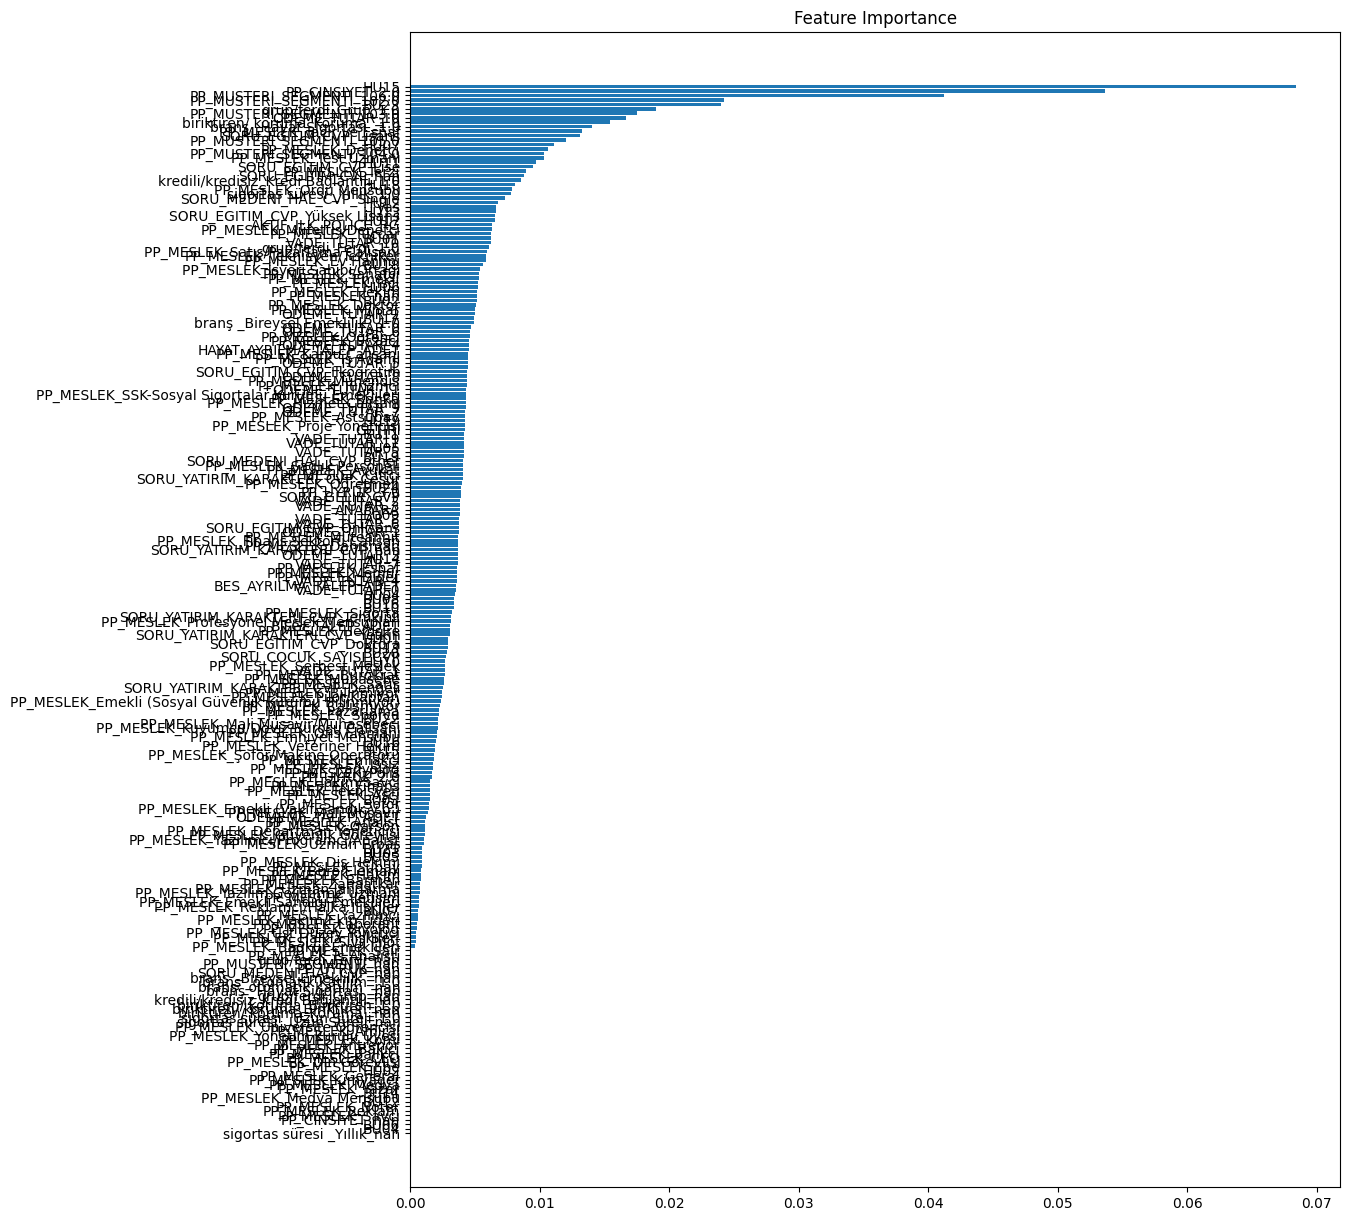

In [18]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(test.columns)[sorted_idx])
plt.title('Feature Importance')

In [19]:
temp = overall_probs

In [20]:
res = temp[0]+temp[1]+temp[2]+temp[3]+temp[4]

In [21]:
res = pd.DataFrame(res/5)

In [22]:
res = pd.DataFrame(np.argmax(res, axis=1))

In [23]:
sub["LABEL"] = res[0]

In [24]:
sub["LABEL"] = le.inverse_transform(sub["LABEL"])

In [25]:
sub.LABEL.value_counts()

LABEL
UA      135047
HU14     20001
HU07     18498
HU06     12856
HU19      4623
HU12      3384
HU11      1142
HU15        80
Name: count, dtype: int64

In [26]:
sub

,MUSTERI_ID,LABEL
0,15b29e51dff893ac19bcbc96c96d1cda0307b4e0edafcd...,UA
1,7532c2d4751858dd8e7eb3f26c61af568fd3b2a6aa2f32...,UA
2,47498c1c6161aea484b0eed7997846919ca9287684aee4...,UA
3,48fe7f96c7e04326f1669b4ae5bdc5ae030da6b8c26498...,UA
4,26dbe514ebfdb7b664760c07f94d0bf0b297528cd5a358...,UA
...,...,...
195626,a81089c7050cfa5bdb47d519cfc616f66aa28bc5bda0b5...,UA
195627,fd4362b714e47318627997b801111f34b25c243e6ae550...,HU07
195628,bf0aba86aa8ece82920ce0fea1d1a013d0f80f3761ad47...,UA
195629,7cf9130d00d3393bb1a1f3b1815eb267c7546e90fc466a...,UA


In [27]:
sub.to_csv("xgboost_21_withnan.csv",index=False)

In [28]:
# categorical data handilign
# cat binnig
# missing data düzelmet
# feature enginaar
# sayısal min max std
# xgboost conf
# optuna
# excelden nan değerleri olanları çek
# az balanced verileri sil
